In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
#Thư viện
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import nltk
import keras

In [3]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-11-24 12:07:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-24 12:07:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-24 12:07:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove

In [6]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
df_train=pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-05/train.tsv", sep="\t")
df_test=pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-05/test.tsv", sep="\t")

In [8]:
df_train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [9]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [10]:
print("các labels: ",df_train["Sentiment"].unique())

các labels:  [1 2 3 4 0]


**Pre-processing**

In [11]:
#làm sạch dữ liệu
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [12]:
data_train=list(df_train.Phrase.map(clean_text))
data_test=list(df_test.Phrase.map(clean_text))

In [13]:
print(data_train[0:5])

['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .', 'a series of escapades demonstrating the adage that what is good for the goose', 'a series', 'a', 'series']


In [14]:
texts_train = df_train["Phrase"].to_list()
texts_train = [text.lower() for text in texts_train ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts_train = [nltk.tokenize.word_tokenize(text) for text in texts_train]    # tách câu thành một list các từ

print(tokenized_texts_train[0])

['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.']


In [15]:
texts_test = df_test["Phrase"].to_list()
texts_test = [text.lower() for text in texts_test ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts_test = [nltk.tokenize.word_tokenize(text) for text in texts_test]    # tách câu thành một list các từ

print(tokenized_texts_test[0])

['an', 'intermittently', 'pleasing', 'but', 'mostly', 'routine', 'effort', '.']


In [16]:
import io
import numpy as np
def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab, matrix = [], []
    i=0
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocab.append(tokens[0])
        matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix)

In [17]:
vocab, matrix = load_word_embeddings("glove.6B.100d.txt")
matrix

array([[-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
         0.27062 ],
       [-0.10767 ,  0.11053 ,  0.59812 , ..., -0.83155 ,  0.45293 ,
         0.082577],
       [-0.33979 ,  0.20941 ,  0.46348 , ..., -0.23394 ,  0.47298 ,
        -0.028803],
       ...,
       [ 0.36088 , -0.16919 , -0.32704 , ...,  0.27139 , -0.29188 ,
         0.16109 ],
       [-0.10461 , -0.5047  , -0.49331 , ...,  0.42527 , -0.5125  ,
        -0.17054 ],
       [ 0.28365 , -0.6263  , -0.44351 , ...,  0.43678 , -0.82607 ,
        -0.15701 ]])

In [18]:
## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding

In [19]:
# Tạo một dictionary, có nhiệm vụ là một ánh xạ từ ảnh sang mã số, mã số được bắt đầu từ 2 vì số 0 và 1 được dành cho trường hợp đặc biệt
word_to_index = {word: index+2 for index, word in enumerate(vocab)}

In [20]:
# Do do mã số được bắt đầu từ 2, nên cần thêm 2 vector vào đàu ma trận
embedding_matrix = np.pad(matrix, [[2,0],[0,0]], mode='constant', constant_values =0.0)
print(embedding_matrix)

# Khi đó, __PADDED_INDEX__ dùng dòng đầu tiên của  embedding_matrix
# __UNKNOWN_WORD__ dùng dòng thứ hai của embedding_matrix

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
 ...
 [ 0.36088  -0.16919  -0.32704  ...  0.27139  -0.29188   0.16109 ]
 [-0.10461  -0.5047   -0.49331  ...  0.42527  -0.5125   -0.17054 ]
 [ 0.28365  -0.6263   -0.44351  ...  0.43678  -0.82607  -0.15701 ]]


In [21]:
def convertData2Index(tokenized_texts):
  X = []
  for text in tokenized_texts:
      cur_text_indices = []
      for word in text:
          if word in word_to_index:
              cur_text_indices.append(word_to_index[word])    ## map từ word sang index
          else:
              cur_text_indices.append(__UNKNOWN_WORD__)       ## gán unknown cho từ không có trong bộ glove
      X.append(cur_text_indices)

  ## pad data cho có cùng chiều dài
  X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X,       # sequences: list các câu có độ dài không bằng nhau
                                                    padding='post')    # vị trí pad là 'pre' (trước) hoặc 'post' (sau)
  return X

In [22]:
X = convertData2Index(tokenized_texts_train)
y = df_train["Sentiment"].values 
X_test = convertData2Index(tokenized_texts_test)

**1. Hãy dùng bộ pre-train glove.6b.100 huấn luyện mô hình LSTM như sau:**

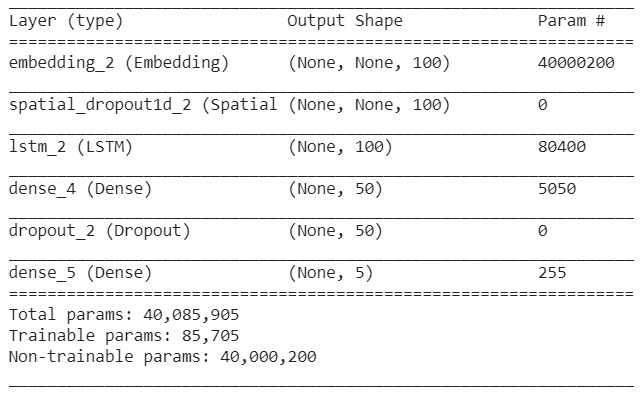

In [23]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=False)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

spatial_dropout1D = tf.keras.layers.SpatialDropout1D(rate = 0.4)(embed)
lstm = LSTM(units=100,                          ## units: kích thước của hidden_state trong LSTM
            return_sequences=False)(spatial_dropout1D)      ## return_sequences: LSTM trả về toàn bộ  hay là trả về hidden_state cuối cùng

dense_1 = Dense(units=50, activation=keras.activations.relu)(lstm)

dropout = Dropout(rate=0.3)(dense_1)

dense_2 = Dense(units=5, activation='softmax')(dropout)
model = Model(inputs=inputs,
              outputs=dense_2)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
            # loss = 'mse',
            # metrics = ['categorical_accuracy'])
            metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         40000200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_valid: ", X_valid.shape)

Shape of X_train:  (124848, 53)
Shape of X_valid:  (31212, 53)


In [25]:
%%time
mc = tf.keras.callbacks.ModelCheckpoint(filepath="lstm.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
# Train
history = model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          # batch_size=64,
          epochs=20,
          callbacks=[mc])

model.load_weights("lstm.h5")
_, val_acc = model.evaluate(X_valid, y_valid)
print("Accuracy on valid: ", val_acc)

Epoch 1/20
3902/3902 [==============================] - 45s 11ms/step - loss: 1.1332 - accuracy: 0.5449 - val_loss: 1.0026 - val_accuracy: 0.5894
Epoch 2/20
3902/3902 [==============================] - 44s 11ms/step - loss: 1.0336 - accuracy: 0.5785 - val_loss: 0.9683 - val_accuracy: 0.6083
Epoch 3/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9993 - accuracy: 0.5887 - val_loss: 0.9384 - val_accuracy: 0.6147
Epoch 4/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9762 - accuracy: 0.5990 - val_loss: 0.9082 - val_accuracy: 0.6229
Epoch 5/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9631 - accuracy: 0.6045 - val_loss: 0.8951 - val_accuracy: 0.6267
Epoch 6/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9501 - accuracy: 0.6083 - val_loss: 0.8896 - val_accuracy: 0.6338
Epoch 7/20
3902/3902 [==============================] - 45s 12ms/step - loss: 0.9391 - accuracy: 0.6138 - val_loss: 0.8784 -

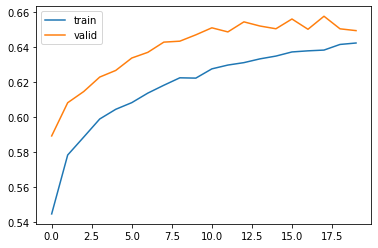

In [26]:
# plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

In [28]:
#predict
arr = model.predict(X_test, verbose=0)

In [29]:
#get label of Phrase
sentiment_predict = []
for i in range(arr.shape[0]):
  sentiment_predict.append(np.argmax(arr[i]))

In [30]:
df_test2 = df_test.copy()
df_test2['Sentiment predict'] = sentiment_predict

In [31]:
df_test2.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment predict
9576,165637,8931,treat me like a fool,2
25244,181305,9694,", nasty , glibly cynical",1
144,156205,8548,accomplished instead of all this specious Holl...,3
37732,193793,10305,potentially terrific,3
6810,162871,8808,quest,2
64844,220905,11771,cheerful enough but imminently forgettable,3
26595,182656,9756,revered TV show,2
43861,199922,10632,still feels like an ugly knot tightening in yo...,0
40042,196103,10431,with pentacostal practices in general and thea...,2
12642,168703,9080,parable,2


**2. Thay LSTM trong mô hình trên bằng GRU. So sánh thời gian, độ chính xác và đưa ra nhận xét**

In [32]:
from tensorflow.keras.layers import GRU
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=False)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

spatial_dropout1D = tf.keras.layers.SpatialDropout1D(rate = 0.4)(embed)
gru = GRU(units=100, name = 'gru')(spatial_dropout1D)       # keras.layers.GRU(200, name="gru")

dense_1 = Dense(units=50, activation=keras.activations.relu)(gru)

dropout = Dropout(rate=0.3)(dense_1)

dense_2 = Dense(units=5, activation='softmax')(dropout)
model_2 = Model(inputs=inputs,
              outputs=dense_2)

model_2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         40000200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 100)         0         
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [33]:
%%time
mc = tf.keras.callbacks.ModelCheckpoint(filepath="gru.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
# Train
history_2 = model_2.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          # batch_size=64,
          epochs=20,
          callbacks=[mc])

model_2.load_weights("gru.h5")
_, val_acc = model_2.evaluate(X_valid, y_valid)
print("Accuracy on valid: ", val_acc)

Epoch 1/20
3902/3902 [==============================] - 44s 11ms/step - loss: 1.1030 - accuracy: 0.5564 - val_loss: 0.9677 - val_accuracy: 0.6037
Epoch 2/20
3902/3902 [==============================] - 45s 11ms/step - loss: 1.0064 - accuracy: 0.5875 - val_loss: 0.9303 - val_accuracy: 0.6153
Epoch 3/20
3902/3902 [==============================] - 43s 11ms/step - loss: 0.9813 - accuracy: 0.5955 - val_loss: 0.9150 - val_accuracy: 0.6234
Epoch 4/20
3902/3902 [==============================] - 45s 12ms/step - loss: 0.9619 - accuracy: 0.6045 - val_loss: 0.9026 - val_accuracy: 0.6260
Epoch 5/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9487 - accuracy: 0.6095 - val_loss: 0.8969 - val_accuracy: 0.6314
Epoch 6/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9388 - accuracy: 0.6130 - val_loss: 0.8783 - val_accuracy: 0.6349
Epoch 7/20
3902/3902 [==============================] - 44s 11ms/step - loss: 0.9297 - accuracy: 0.6178 - val_loss: 0.8690 -

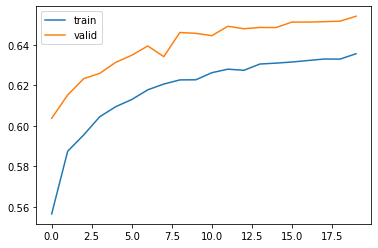

In [35]:
# plot training history
plt.plot(history_2.history['accuracy'], label='train')
plt.plot(history_2.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

***Nhận xét:***

*   LSTM: 
  + Accuracy trên tập valid: 0.6560617685317993
  + Time: 11min 57s


*   GRU:
  + Accuracy trên tập valid: 0.6518005728721619
  + Time: 12min 54s

 => Khi thay LSTM bằng GRU, accuracy giảm nhưng không đáng kể dù thời gian train tăng lên (nhưng tăng không nhiều)








**3. Tìm hiểu Convolution1D và mô hình sau:**

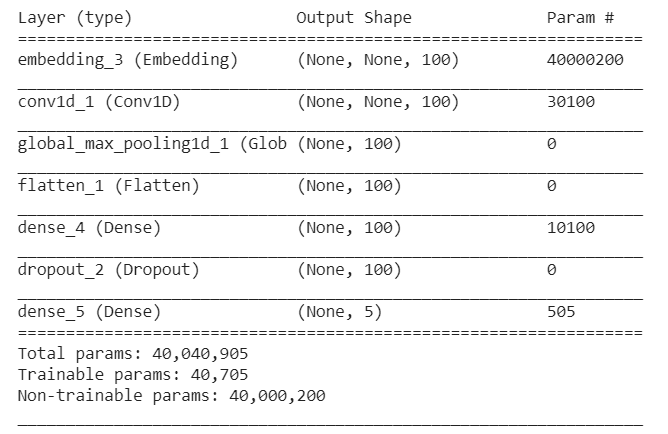

In [36]:
from tensorflow.keras.layers import Convolution1D, Flatten, GlobalMaxPooling1D
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=False)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

convolution1D = Convolution1D(filters=100,
                                 kernel_size=3,
                                 strides= 2,
                                 padding='valid',
                                 activation=tf.nn.elu)(embed)
globalmaxpooling1D = GlobalMaxPooling1D()(convolution1D)

flatten = Flatten()(globalmaxpooling1D)                               

dense_1 = Dense(units=100, activation=keras.activations.relu)(flatten)

dropout = Dropout(rate=0.3)(dense_1)

dense_2 = Dense(units=5, activation='softmax')(dropout)
model_3 = Model(inputs=inputs,
              outputs=dense_2)

model_3.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model_3.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         40000200  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         30100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [37]:
%%time
mc = tf.keras.callbacks.ModelCheckpoint(filepath="model_3.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
# Train
history_3 = model_3.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=20,
          callbacks=[mc])

model_3.load_weights("model_3.h5")
_, val_acc = model_3.evaluate(X_valid, y_valid)
print("Accuracy on valid: ", val_acc)

Epoch 1/20
3902/3902 [==============================] - 36s 9ms/step - loss: 1.0089 - accuracy: 0.5848 - val_loss: 0.9421 - val_accuracy: 0.6094
Epoch 2/20
3902/3902 [==============================] - 12s 3ms/step - loss: 0.9331 - accuracy: 0.6106 - val_loss: 0.9477 - val_accuracy: 0.6051
Epoch 3/20
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8994 - accuracy: 0.6243 - val_loss: 0.9066 - val_accuracy: 0.6239
Epoch 4/20
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8713 - accuracy: 0.6351 - val_loss: 0.9051 - val_accuracy: 0.6261
Epoch 5/20
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8503 - accuracy: 0.6440 - val_loss: 0.9002 - val_accuracy: 0.6270
Epoch 6/20
3902/3902 [==============================] - 35s 9ms/step - loss: 0.8318 - accuracy: 0.6511 - val_loss: 0.8973 - val_accuracy: 0.6305
Epoch 7/20
3902/3902 [==============================] - 12s 3ms/step - loss: 0.8164 - accuracy: 0.6561 - val_loss: 0.9121 - val_ac

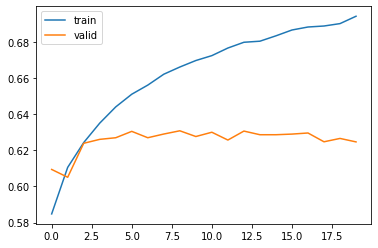

In [38]:
# plot training history
plt.plot(history_3.history['accuracy'], label='train')
plt.plot(history_3.history['val_accuracy'], label='valid')
plt.legend()
plt.show()

**Convolution1D:** 
- Giảm chiều input
- Giúp tính toán nhanh hơn

Accuracy trên tập valid: 0.6304946541786194

Dù accuracy trên tập valid giảm nhưng thời gian train giảm đi đáng kể: 6min 4s 